<a href="https://colab.research.google.com/github/fjxmlinyang/CNN_Project_car_classification/blob/main/Yang_Deep_Learning_Project_car_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project(CNN)- Car classification


# 1 Introduction

The followings are some info for this project:
1. This project is for car classification for [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). We focus on study deep learning model of Convolutional Neural Networks(CNN) in this project.
2. The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.
3. Since it is difficult to directly train deep learning model on this dataset with the limited number of images. We will using a pre-trained model with transfer learning to train the model. All layers will be fine tuned and the last fully connected layer will be replaced entirely. 
4. A common approch used in deep learning to utilize the pretrained model is on [imagenet](http://www.image-net.org/) and fine-tune on our own dataset, i.e. car dataset. 
5. This project can show how to train and fine-tune a deep learning model using pytorch.

![](https://ai.stanford.edu/~jkrause/cars/class_montage.jpg)


## 1.1 Transfer Learning
Transfer learning is one of the most widely used technologies in deep learning and computer vision. If you are not familar with the concept of transfer learning, please refer to our course materials.

![](https://cdn-images-1.medium.com/max/2000/1*9GTEzcO8KxxrfutmtsPs3Q.png)

# 2 Data Loading/Ingestion
Ingestion includes: collection/storage

1. Here we will load and extract our dataset files
2. We are using the Stanford car dataset, which contains 196 classes.
3. Dataset (196 classes):

Train folder: 8144 images, avg: 41.5 images per class.

Test folder: 8041 images, avg: 41.0 images per class.



## 2.1 mount google drive to colab

In [2]:
# install pydrive to load data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.2 Copy file from google drive to colab

In [3]:
# copy dataset from google drive to colab. https://drive.google.com/open?id=1qcSFJ_2Ouom95QYDI3n498JEnqQd71vx
#!cp ./drive/My\ Drive/stanford_car_dataset.zip ./
#!cp ./content/drive/My\ Drive/Colab\ Notebooks/DeepLearningCNNCarProject/stanford_car_dataset.zip ./
#/content/drive/MyDrive/Colab Notebooks/DeepLearningCNNCarProject/stanford_car_dataset.zip

## 2.3 Extract dataset files

In [4]:
%%time

!mkdir ./stanford_car_dataset
!unzip -q "/content/drive/My Drive/Colab Notebooks/DeepLearningCNNCarProject/stanford_car_dataset.zip" -d ./stanford_car_dataset



CPU times: user 341 ms, sys: 78.3 ms, total: 419 ms
Wall time: 1min 11s


# 3 Data Exploration /Preparation
Preparation includes: Data validation/clean/transformation/segregation

## 3.1 Load packages

The pytorch have been pre-installled on colab, and we do not need re-install these packages.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms #图像预处理包

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


## 3.2 Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 224x224 images (you can also change the resolution) with random horizontal flip, random rotation and normalization

In [6]:
dataset_dir = "stanford_car_dataset/car_data/car_data/"

In [7]:
# data transformation, you can try different transformation/ data augmentation here
# note: no data augmentation for test data
# [0.485, 0.456, 0.406] is the normalized mean value of ImageNet, and [0.229, 0.224, 0.225] denotes the std of ImageNet.
width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 # transforms.RandomHorizontalFlip(),
                                 # transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [8]:
# create datasets
# https://zhuanlan.zhihu.com/p/184911006
# The batch size defines the number of samples that will be propagated through the network.
# num_workers (int, optional) – 用多少个子进程加载数据



dataset_train = torchvision.datasets.ImageFolder(root=dataset_dir+'train', transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True, num_workers=2)

dataset_test = torchvision.datasets.ImageFolder(root=dataset_dir+'test', transform=test_tfms)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False, num_workers=2)


# 4 Model Training and Evaluation


## 4.1 Model Preparation


### 4.1.1 Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going



In [9]:
# Visualizing the model predictions

def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    # 训练模型一共需要num_epochs个迭代周期
    losses = []
    accuracies = []
    test_accuracies = []  

    # set the model to train mode initially
    model.train()
    #tqdm显示进度
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            # inpuots = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()


            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()


        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        #switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)

        #re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies


### 4.1.2 Evaluate function on training data
This function is called out after each epoch of training on the training data. We then measure the accuracy of the model.

In [10]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():

        for i, data in enumerate(testloader, 0):
          
            images, labels = data # 前面是input/labels, 这里被换成images, labels
            # images = images.to(device).half() #uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)


            total += labels.size(0)
            correct += (predicted == labels).sum().item()



        test_acc = 100.0 * correct / total
        print('Accuracy of the network on the test images: %d %%' % (test_acc))
        return test_acc

# Accuracy (ACC) 

## 4.3 Model training

### 4.3.1 Define parameters

In [11]:

NUM_CAR_CLASSES = 196

# here directly using alexnet &resnet34
model_ft = models.alexnet(pretrained=True)
#model_ft = models.resnet34(pretrained=True)

# Freezing model parameters and defining the fully coneected network to be attached to the model
# Loss function and the optimizer.
# We there after put the model on the GPUs
# for param in model_ft.parameters():
#     param.require_grad = False

# replace the last fc layer with an untrained one (requires grad by default)

# for alexnet
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

# for resnet34
# num_ftrs = model_ft.fc.in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)

model_ft = model_ft.to(device)

# uncomment this block for half precision model
"""
model_ft = model_ft.half()

for layer in model_ft.modules():
    if isinstacne(layer, nn.BatchNorm2d):
        layer.float()
"""

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)


"""
probability not the best metric to track, but we are tracking 
the training accuracy and measuring whether it increases by at least 0.9 per epoch
and if it has not increased by 0.9 reduce the lr by 0.1x.
However, in this model it did not befefit me.
"""

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


### 4.3.2 Model training

In [12]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1, duration: 73 s, loss: 5.2596, acc: 0.8456


  5%|▌         | 1/20 [02:25<45:55, 145.04s/it]

Accuracy of the network on the test images: 0 %
Epoch 2, duration: 73 s, loss: 5.0382, acc: 2.9412


 10%|█         | 2/20 [04:49<43:25, 144.76s/it]

Accuracy of the network on the test images: 5 %
Epoch 3, duration: 73 s, loss: 4.3990, acc: 8.1985


 15%|█▌        | 3/20 [07:13<40:59, 144.70s/it]

Accuracy of the network on the test images: 10 %
Epoch 4, duration: 73 s, loss: 3.8133, acc: 14.5711


 20%|██        | 4/20 [09:38<38:33, 144.62s/it]

Accuracy of the network on the test images: 13 %
Epoch 5, duration: 73 s, loss: 3.3651, acc: 21.9853


 25%|██▌       | 5/20 [12:02<36:08, 144.59s/it]

Accuracy of the network on the test images: 16 %
Epoch 6, duration: 73 s, loss: 2.9988, acc: 27.8922


 30%|███       | 6/20 [14:28<33:47, 144.85s/it]

Accuracy of the network on the test images: 19 %
Epoch 7, duration: 74 s, loss: 2.7298, acc: 32.6225


 35%|███▌      | 7/20 [16:53<31:23, 144.89s/it]

Accuracy of the network on the test images: 20 %
Epoch 8, duration: 73 s, loss: 2.4225, acc: 39.8162


 40%|████      | 8/20 [19:17<28:57, 144.80s/it]

Accuracy of the network on the test images: 21 %
Epoch 9, duration: 73 s, loss: 1.1188, acc: 68.5049


 45%|████▌     | 9/20 [21:41<26:28, 144.38s/it]

Accuracy of the network on the test images: 34 %
Epoch 10, duration: 73 s, loss: 0.6329, acc: 81.2623


 50%|█████     | 10/20 [24:05<24:03, 144.30s/it]

Accuracy of the network on the test images: 36 %
Epoch 11, duration: 73 s, loss: 0.4174, acc: 87.1078


 55%|█████▌    | 11/20 [26:28<21:37, 144.14s/it]

Accuracy of the network on the test images: 36 %
Epoch 12, duration: 74 s, loss: 0.3018, acc: 90.1593


 60%|██████    | 12/20 [28:54<19:16, 144.51s/it]

Accuracy of the network on the test images: 38 %
Epoch 13, duration: 73 s, loss: 0.2206, acc: 92.8431


 65%|██████▌   | 13/20 [31:19<16:52, 144.59s/it]

Accuracy of the network on the test images: 38 %
Epoch 14, duration: 73 s, loss: 0.1641, acc: 94.8407


 70%|███████   | 14/20 [33:42<14:25, 144.30s/it]

Accuracy of the network on the test images: 39 %
Epoch 15, duration: 73 s, loss: 0.1430, acc: 95.4657


 75%|███████▌  | 15/20 [36:06<12:01, 144.24s/it]

Accuracy of the network on the test images: 39 %
Epoch 16, duration: 73 s, loss: 0.1305, acc: 96.0294


 80%|████████  | 16/20 [38:30<09:36, 144.18s/it]

Accuracy of the network on the test images: 39 %
Epoch 17, duration: 73 s, loss: 0.1347, acc: 95.8456


 85%|████████▌ | 17/20 [40:55<07:12, 144.25s/it]

Accuracy of the network on the test images: 39 %
Epoch 18, duration: 73 s, loss: 0.1260, acc: 96.0539


 90%|█████████ | 18/20 [43:18<04:48, 144.08s/it]

Accuracy of the network on the test images: 39 %
Epoch 19, duration: 73 s, loss: 0.1179, acc: 96.4583


 95%|█████████▌| 19/20 [45:42<02:23, 143.93s/it]

Accuracy of the network on the test images: 39 %
Epoch 20, duration: 73 s, loss: 0.1229, acc: 96.2500


100%|██████████| 20/20 [48:07<00:00, 144.36s/it]

Accuracy of the network on the test images: 39 %
Finished Training


### 4.3.3 As we can see the model reached 90% training accuracy by epoch 10.


Text(0.5, 1.0, 'Test acc')

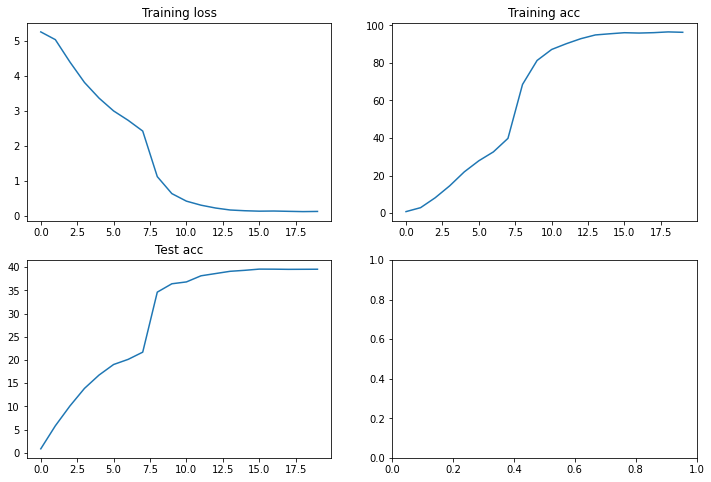

In [17]:
# plot the stats

f,axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title('Training loss')
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title('Training acc')
axarr[1, 0].plot(test_accs)
axarr[1,0].set_title('Test acc')

## 4.4 Evaluate the model on single images (e.g for production)

Next we can use the model on our own images. For that we need to tie the class numbers for which the model returns probablities with the names of those classes.


In [18]:
# tie the class indices to their names

def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

classes, c_to_idx = find_classes(dataset_dir + 'train')

In [22]:
# test the model on random images

# switch the model to evaluation mode to make dropout and batch norm work in eval mode

model_ft.eval()

# transforms for the input image

loader = transforms.Compose([transforms.Resize((400, 400)), transforms.ToTensor(), 
                             transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

image = Image.open(dataset_dir + "test/Mercedes-Benz C-Class Sedan 2012/01977.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

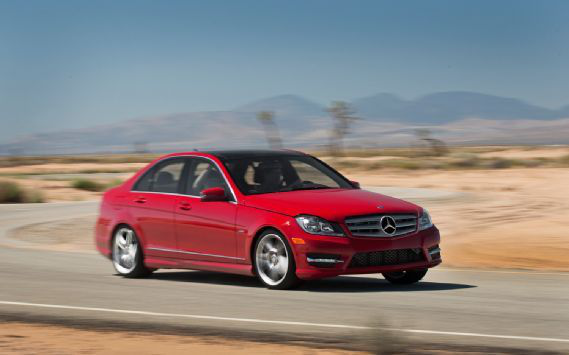

Cadillac CTS-V Sedan 2012 confidence: 7.170183181762695


In [23]:
# get the calss name of the prediction
display(Image.open(dataset_dir+"test/Mercedes-Benz C-Class Sedan 2012/01977.jpg"))
print(classes[predicted.item()], 'confidence:', conf.item())

# 5 Model Prediction/Deployment and Monitor

In [27]:
PATH = 'car_model.pth'
torch.save(model_ft.state_dict(), PATH)

In [28]:
model_loaded = torch.load(PATH)
model_loaded


OrderedDict([('features.0.weight',
              tensor([[[[ 9.3264e-02,  6.0800e-02,  6.7535e-02,  ...,  5.7732e-02,
                          7.7109e-03,  3.9768e-02],
                        [ 6.2631e-02,  1.5722e-02,  3.3614e-02,  ...,  2.0710e-02,
                         -1.6792e-02, -6.2500e-03],
                        [ 8.1592e-02,  3.2976e-02,  5.1624e-02,  ...,  4.3540e-02,
                          1.3406e-02,  1.5197e-02],
                        ...,
                        [ 9.4738e-02,  9.5784e-02,  6.1825e-02,  ..., -2.3037e-01,
                         -1.4081e-01, -1.1091e-01],
                        [ 5.5262e-02,  7.2377e-02,  5.0269e-02,  ..., -2.1948e-01,
                         -1.1466e-01, -9.4614e-02],
                        [ 5.7157e-02,  6.6913e-02,  4.0180e-02,  ..., -1.2651e-01,
                         -9.8166e-02, -7.4394e-02]],
              
                       [[-5.6268e-02, -5.4640e-02, -7.4499e-02,  ...,  1.4712e-02,
                         -2

In [ ]:
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
# import torch.nn as nn
# from torchvision import models

# class BuildAlexNet(nn.Module):
#     def __init__(self, model_type, n_output):
#         super(BuildAlexNet, self).__init__()
#         self.model_type = model_type
#         if model_type == 'pre':
#             model = models.alexnet(pretrained=True)
#             self.features = model.features
#             fc1 = nn.Linear(9216, 4096)
#             fc1.bias = model.classifier[1].bias
#             fc1.weight = model.classifier[1].weight
            
#             fc2 = nn.Linear(4096, 4096)
#             fc2.bias = model.classifier[4].bias
#             fc2.weight = model.classifier[4].weight
            
#             self.classifier = nn.Sequential(
#                     nn.Dropout(),
#                     fc1,
#                     nn.ReLU(inplace=True),
#                     nn.Dropout(),
#                     fc2,
#                     nn.ReLU(inplace=True),
#                     nn.Linear(4096, n_output))  
#             #或者直接修改为
# #            model.classifier[6]==nn.Linear(4096,n_output)
# #            self.classifier = model.classifier
#         if model_type == 'new':
#             self.features = nn.Sequential(
#                     nn.Conv2d(3, 64, 11, 4, 2),
#                     nn.ReLU(inplace = True),
#                     nn.MaxPool2d(3, 2, 0),
#                     nn.Conv2d(64, 192, 5, 1, 2),
#                     nn.ReLU(inplace=True),
#                     nn.MaxPool2d(3, 2, 0),
#                     nn.Conv2d(192, 384, 3, 1, 1),
#                     nn.ReLU(inplace = True),
#                     nn.Conv2d(384, 256, 3, 1, 1),
#                     nn.ReLU(inplace=True),
#                     nn.MaxPool2d(3, 2, 0))
#             self.classifier = nn.Sequential(
#                     nn.Dropout(),
#                     nn.Linear(9216, 4096),
#                     nn.ReLU(inplace=True),
#                     nn.Dropout(),
#                     nn.Linear(4096, 4096),
#                     nn.ReLU(inplace=True),
#                     nn.Linear(4096, n_output))
            
#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         out  = self.classifier(x)
#         return out

In [ ]:
# import numpy as np
# from torch.autograd import Variable
# import torch

# if __name__ == '__main__':
#     model_type = 'pre'
#     n_output = 10
#     alexnet = BuildAlexNet(model_type, n_output)
#     print(alexnet)
    
#     x = np.random.rand(1,3,224,224)
#     x = x.astype(np.float32)
#     x_ts = torch.from_numpy(x)
#     x_in = Variable(x_ts)
#     y = alexnet(x_in)